# Disaster tweets

*(Author: Aitor Pérez Pérez)*

In this notebook we use different ML techniques in order to predict whether a given tweet refers to a natural catastrophe.

## 1. Summary

To see its limitation, we will only use the actual tweet, without the tweet metadata. The different steps we go trough are listed below, including some data preprocessing, exploration and several ML techniques in increasing order of complexity:

* **Preprocessing and data exploration**
    * Loading data
    * Exploratory data analysis (EDA)
    * Vectorization
* **Model training and validation**
    * Preparation
    * Multinomial Naive Bayes
    * Logistic regression
    * Multilayer Perceptron (Simple neural network)
    * Deep Neural Network
    * Genetic algorithm

## 2. Preprocessing and data exploration
### 2.1. Loading data
We load the datasets using the common Python library *pandas*.

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# We drop the tweet metadata
train = train.drop(['id', 'keyword', 'location'], axis=1)
test = test.drop(['keyword', 'location'], axis=1)

train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


We check the total number of tweets.

In [40]:
train.shape

(7613, 2)

### 2.2. Exploratory data analysis (EDA)
We now try to get acquainted with the dataset. In this case, the dataset is simple, however we need to check for missing values and duplicates. Additionally, as we are working with text we perform some cleanup.

#### NA analysis

We make sure we do not have NA values in our data.

In [41]:
train.isna().any()

text      False
target    False
dtype: bool

#### Duplicates

Similarly, we check and remove duplicates. In this case, we see that even tweets with the same text are duplicated and labeled with both disaster and non-disaster labels.

In [42]:
train[train.duplicated()]

,text,target
48,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
115,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
119,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0
164,Experts in France begin examining airplane deb...,1
630,To fight bioterrorism sir.,1
...,...,...
7600,Evacuation order lifted for town of Roosevelt:...,1
7607,#stormchase Violent Record Breaking EF-5 El Re...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


In [43]:
test[test.duplicated()]

,id,text


In [44]:
train = train.drop_duplicates(ignore_index=True)
train.shape

(7521, 2)

#### Total number of tweets per category level

We now want to know whether we have unbalanced data, i.e. whether we have many more disaster tweets than non-disaster ones. This would change the way we approach the problem. In our case, we do not have a significant difference, so we proceed as planned.

Text(0, 0.5, 'Number of tweets')

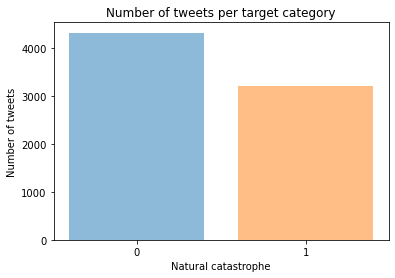

In [45]:
train_gp = train.groupby('target', as_index=False).count()

fig, ax = plt.subplots()
ax.bar(train_gp['target'].astype('string'), train_gp['text'], color=['tab:blue', 'tab:orange'], alpha=0.5)
ax.set_title('Number of tweets per target category')
ax.set_xlabel('Natural catastrophe')
ax.set_ylabel('Number of tweets')

#### Text cleanup

Next, we will apply some standard text processing to the tweets, for instance removing common, rather meaningless words like "a" or "the" and some slang. To do so, we will use the *NLTK* library as well as the standard *string* Python library.

In [46]:
import string
from nltk.corpus import stopwords

def clean_text(raw):
    # Remove punctuation characters
    no_punct = [char for char in raw if char not in string.punctuation]
    no_punct = ''.join(no_punct)

    # Lowercase
    lowercase = no_punct.lower()

    # Remove stopwords
    all_stopwords = stopwords.words('english') + ['im', 'u', 'ur', 'ure', '2', '4', 'amp', 'via']
    no_stopwords = [word for word in lowercase.split() if word.lower() not in all_stopwords]
    no_stopwords = ' '.join(no_stopwords)

    return no_stopwords

train['clean_text'] = train['text'].apply(clean_text)
test['clean_text'] = test['text'].apply(clean_text)

train.head()

,text,target,clean_text
0,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...


#### Most common words

To have an intuitive idea of what both disaster and non-disaster tweets look like, let us have a look at the most common words for both of them. An intuitive way of visualize them is using word clouds.

In [47]:
from collections import Counter

disaster_terms = ' '.join(train['clean_text'][train['target'] == 1]).split()
non_disaster_terms = ' '.join(train['clean_text'][train['target'] == 0]).split()

disaster_top_terms = Counter(disaster_terms).most_common(10)
non_disaster_top_terms = Counter(non_disaster_terms).most_common(10)

We generate wordclouds with the most repeated terms for both disaster and non-disaster tweets.

In [48]:
from wordcloud import WordCloud

def gen_wordcloud(top_terms):
    # Compute term frequencies based on inverse ranking
    freqs = {}
    n = len(top_terms)
    i = 0
    for term in top_terms:
        freqs[term[0]] = n - i
        i += 1

    # Create and store word cloud
    wc = WordCloud(background_color='white', colormap='tab20c')
    return wc.generate_from_frequencies(freqs)

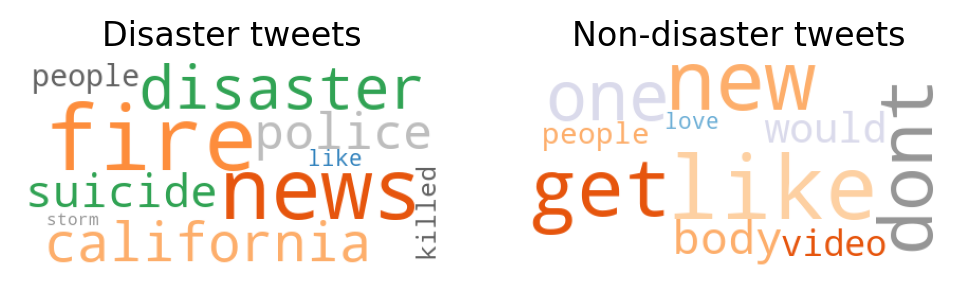

In [49]:
titles = ['Disaster tweets', 'Non-disaster tweets']
wordclouds = [
    gen_wordcloud(disaster_top_terms),
    gen_wordcloud(non_disaster_top_terms)
]

fig, axs = plt.subplots(1, 2, figsize=(6,4), dpi=200)
for i in range(2):
    axs[i].imshow(wordclouds[i])
    axs[i].set_title(titles[i])
    axs[i].axis('off')

### 2.3. Vectorization

We generate vector counts for both train and test data using scikit's *CountVectorizer*. In particular, we fit the vectorizer only with the train tokens, and use it to transform both train and test data. We use a simple approach by just counting the number of times the tokens appear in a tweet, and we consider tokens to be both 1 and 2-grams, i.e. words and sets of 2 consecutive words.

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

cvec = CountVectorizer(ngram_range=(1, 2))
cvec.fit(train['clean_text'])
X_train = cvec.transform(train['clean_text'])
X_test = cvec.transform(test['clean_text'])
y_train = train['target']

X_train.shape, X_test.shape, y_train.shape

((7521, 74578), (3263, 74578), (7521,))

## 3. Model training and validation

We may now start training different models and checking their performance. For each of them, we use cross validation to tune some of their hyperparameters and to have an idea of their accuracy. As metric, we use the F1-score, i.e. the harmonic mean of precision and recall.

### 3.1. Preparation

We define here some helper functions that we will use across the different models in order to simplify some recurrent tasks.

In [51]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def cv_score(clf, X, y):
    cv = KFold(n_splits=3, shuffle=True, random_state=0)
    score = np.mean(cross_val_score(clf, X, y, cv=cv, scoring='f1'))
    return score

In [52]:
def plot_heatmap(models, param_grid, field):
    hyperparams = list(param_grid.keys())

    values = pd.DataFrame(
        index=param_grid[hyperparams[0]][::-1],
        columns=param_grid[hyperparams[1]],
        dtype='float64'
    )

    for params in ParameterGrid(param_grid):
        key = '-'.join([str(x) for x in params.values()])
        values.loc[params[hyperparams[0]], params[hyperparams[1]]] = models[key][field]

    sns.heatmap(values, annot=True, fmt='.4f', cmap='Blues')
    plt.xlabel(hyperparams[1])
    plt.ylabel(hyperparams[0])

### 3.2. Multinomial Naive Bayes

Because our features are word counts, they are integer and discrete. It is hence interesting to consider a multinomial Naive Bayes model to predict the target variable. We define a parameter grid upon which we will find the combination of parameters yielding the highest score.

In [53]:
from sklearn.naive_bayes import MultinomialNB

param_grid = {
    'alpha': [0.1, 0.5, 1],
    'fit_prior': [True, False]
}

In [54]:
from sklearn.model_selection import ParameterGrid

models = {}
for params in ParameterGrid(param_grid):
    key = '-'.join([str(x) for x in params.values()])
    models[key] = {}

    models[key]['model'] = MultinomialNB(
        alpha=params['alpha'],
        fit_prior=params['fit_prior']
    )

    models[key]['score'] = cv_score(models[key]['model'], X_train, y_train)

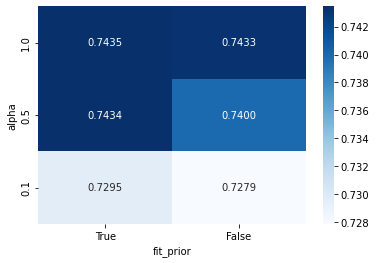

In [55]:
plot_heatmap(models, param_grid, 'score')

### 3.3. Logistic Regression
Logistic regression is another ML technique used for classification. Provided that the size of our data is still moderate, we train some models using this approach.

In [56]:
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': [1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga']
}

In [57]:
%%capture --no-display

models = {}
for params in ParameterGrid(param_grid):
    key = '-'.join([str(x) for x in params.values()])
    models[key] = {}

    models[key]['model'] = LogisticRegression(
        solver=params['solver'],
        C=params['C'],
        max_iter=500
    )

    models[key]['score'] = cv_score(models[key]['model'], X_train, y_train)

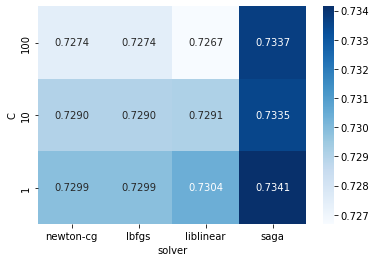

In [58]:
plot_heatmap(models, param_grid, 'score')

### 3.4. Multilayer perceptron (Simple neural network)

Moving on to more complex techniques, we try a simple neural network with one single hidden layer. For that, we use scikit's *MLPClassifier*. At this stage, we revectorize the tweets by using scikit's *TfidfVectorizer*. This vectorizer not only takes the word counts into account but normalizes them by considering their global frequence. Later, we search in the parameter grid the best combination of parameters.

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(ngram_range=(1, 2))
tfidf_vec.fit(train['clean_text'])
X_train = tfidf_vec.transform(train['clean_text'])
X_test = tfidf_vec.transform(test['clean_text'])
y_train = train['target']

In [60]:
from sklearn.neural_network import MLPClassifier

param_grid = {
    'activation': ['tanh', 'relu'],
    'hidden_layer_sizes': [10, 20, 40]
}

In [61]:
models = {}
for params in ParameterGrid(param_grid):
    key = '-'.join([str(x) for x in params.values()])
    models[key] = {}

    print('Training', key)
    models[key]['model'] = MLPClassifier(
        activation=params['activation'],
        hidden_layer_sizes=(params['hidden_layer_sizes'],),
        max_iter=10000
    )

    models[key]['score'] = cv_score(models[key]['model'], X_train, y_train)

Training tanh-10
Training tanh-20
Training tanh-40
Training relu-10
Training relu-20
Training relu-40


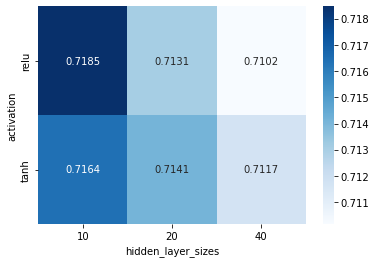

In [62]:
plot_heatmap(models, param_grid, 'score')

### 3.5. Deep Neural Network

We now want to implement a deep neural network with a more complex architecture, using the library *keras*. In particular, we use a common approach to NLP problems which includes the text vectorization. We set a first Embedding layer, followed by two one-dimensional convolutional layers and a GlobalMaxPooling layer, and we finally set a Dense layer. In between some of these steps, we use Dropout layers in order to prevent overfitting.

In [63]:
%%capture --no-display

import tensorflow as tf
import tensorflow.keras as keras

from keras.layers import TextVectorization
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import Dense

precision = keras.metrics.Precision()
recall =  keras.metrics.Recall()

train_text, train_label = np.array(train['clean_text']), np.array(train['target'])
test_text = test['clean_text']

print(train_text.shape)
print(train_label.shape)
print(test_text.shape)

2021-11-12 19:50:14.028420: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We create helper functions to build a model with a given set of hyperparameters and to train a given model.

In [64]:
def build_model(params):
    dropout_rate = 0.5

    # Inputs are text strings, then we vectorize them
    inputs = keras.Input(shape=(1,), dtype=tf.string, name='text')

    vectorizer = TextVectorization(
        standardize='lower_and_strip_punctuation',
        max_tokens=params['max_features'],
        output_mode='int',
        output_sequence_length=params['sequence_length'],
    )
    vectorizer.adapt(train_text)
    x = vectorizer(inputs)

    # We use Embedding to map the vectorized text onto a space of dimension embedding_dim
    x = Embedding(params['max_features'] + 1, params['embedding_dim'])(x)
    x = Dropout(dropout_rate)(x)

    # Conv1D + GlobalMaxPooling
    x = Conv1D(params['conv_1_filters'], params['conv_1_kernel_size'], strides=params['conv_1_strides'], activation='relu')(x)
    x = Conv1D(params['conv_2_filters'], params['conv_2_kernel_size'], strides=params['conv_2_strides'], activation='relu')(x)
    x = GlobalMaxPooling1D()(x)

    # Dense hidden layer
    x = Dense(params['dense_layer_size'], activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    # Output layer
    outputs = Dense(1, activation='sigmoid', name='predictions')(x)

    model = keras.Model(inputs, outputs)

    # Compile the model with binary crossentropy loss and an adam optimizer.
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

    return model

In [65]:
def train_model(model, epochs, cv):
    scores = []
    for fold_train_indices, fold_val_indices in cv.split(train_text, train_label):
        fold_train_text = train_text[fold_train_indices]
        fold_train_label = train_label[fold_train_indices]
        fold_val_text = train_text[fold_val_indices]
        fold_val_label = train_label[fold_val_indices]

        model.fit(fold_train_text, fold_train_label, epochs=epochs, verbose=-1)
        fold_scores = model.evaluate(fold_val_text, fold_val_label)

        p = fold_scores[2]
        r = fold_scores[3]
        fold_f1_score = 2/(1/p + 1/r)
        fold_scores.append(fold_f1_score)

        scores.append(fold_scores)

    score = np.mean([fold_score[4] for fold_score in scores])

    return score

We are now ready to build a base model with the hyperparameters below.

In [66]:
# Base model
base_params = {
    'max_features': 10000,
    'sequence_length': 32,
    'embedding_dim': 32,
    'conv_1_filters': 32,
    'conv_1_kernel_size': 3,
    'conv_1_strides': 1,
    'conv_2_filters': 32,
    'conv_2_kernel_size': 3,
    'conv_2_strides': 1,
    'dense_layer_size': 32
}

In [67]:
%%capture --no-display

base_model = build_model(base_params)
epochs = 3
cv = KFold(n_splits=3, shuffle=True, random_state=0)

score = train_model(base_model, epochs, cv)
score

2021-11-12 19:50:14.271166: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


0.8293732528394505

### 3.6. Genetic algorithm

We now want to extend the previous approach in order to fine-tune the numerous parameters in the model. To do so, we could perform a cross-validated search as we have done above with the rest of models. Instead, we will follow an approach that uses a **genetic algorithm** to simulate a **natural selection** process with a population of deep neural networks.

We do so by defining operations to combine (**reproduce**) and **mutate** the models, and simulate a number of generations, with better-performing models having more chances of having offspring than worse-performing ones.

#### Helper functions

The **mutate** function takes a *genotype* (a dictionary of the hyperparameters of a model) and *mutates* it by slightly perturbing its values. The function also clamps *sequence_length* and *max_features* to reasonable maxima, and corrects some hyperparameters from the convolutional layers in order to avoid unfeasible models.

In [68]:
import math

def mutate(genotype):
    for param in genotype.keys():
        # Random number r = 1 + |N(0, 0.2)|, we ensure r >= 1 and typically r < 1.5
        r = 1 + np.abs(np.random.normal(0, 0.2))
        # We decide at random with equal probability whether we take r or 1/r
        perturbed_value = round(np.random.choice([genotype[param] * r, genotype[param] / r]))
        genotype[param] = np.max([1, perturbed_value])

    # Hard-coded maxima
    genotype['sequence_length'] = np.min([32, genotype['sequence_length']])
    genotype['max_features'] = np.min([30000, genotype['max_features']])

    # Fix unfeasible genotypes
    input_size_conv_1 = genotype['sequence_length']
    genotype['conv_1_kernel_size'] = np.min([input_size_conv_1, genotype['conv_1_kernel_size']])

    input_size_conv_2 = math.floor((input_size_conv_1 - (genotype['conv_1_kernel_size'] - genotype['conv_1_strides'])) / genotype['conv_1_strides'])
    genotype['conv_2_kernel_size'] = np.min([input_size_conv_2, genotype['conv_2_kernel_size']])

    # Convert numpy.int64 to int
    for param in genotype.keys():
        genotype[param] = genotype[param].item()

    return genotype

The **reproduce** function takes two *genotypes* and combines them by averaging all the parameters and mutating the resulting genotype with the *mutate* function.

In [69]:
def reproduce(genotype_1, genotype_2):
    genotype = {}
    for param in base_params.keys():
        genotype[param] = round(np.mean([genotype_1[param], genotype_2[param]]))

    return mutate(genotype)

We create a **print_genotype** function to display the parameters of a given model.

In [70]:
def print_genotype(genotype):
    s = str(genotype['max_features']) + ' '
    s += str(genotype['sequence_length']) + ' '
    s += str(genotype['embedding_dim']) + ' '
    s += str(genotype['conv_1_filters']) + '-' + str(genotype['conv_1_kernel_size']) + '-' + str(genotype['conv_1_strides']) + ' '
    s += str(genotype['conv_2_filters']) + '-' + str(genotype['conv_2_kernel_size']) + '-' + str(genotype['conv_2_strides']) + ' '
    s += str(genotype['dense_layer_size'])
    print(s)

The **generation** function simulates one generation for a population of models, represented by their genotypes, by doing two things:
1. Generates the descendant generation of genotypes, by choosing parents and reproducing them, with uneven probabilities so that better-performing models are more likely to be chosen.
2. Trains all resulting models using cross-validation and obtaining a score for each of them. This score allows to sort them by performance and both the models' genotypes and scores are returned.


**Assumption**: The *population* list contains the genotypes in descending order of score.

In [71]:
def generation(population, epochs):
    n = len(population)
    probabilities = np.linspace(1.9, 0.1, n) / n

    children = []
    for i in range(n):
        parents = np.random.choice(population, p=probabilities, size=2, replace=False)
        child = reproduce(parents[0], parents[1])
        children.append(child)

    population = children

    cv = KFold(n_splits=3, shuffle=True)

    scores = []
    for genotype in population:
        print_genotype(genotype)
        try:
            model = build_model(genotype)
            score = train_model(model, epochs, cv)
        except:
            score = 0
        scores.append(score)
        print()

    sorted_tuples = sorted(zip(scores, population), reverse=True)
    return {
        'population': [genotype for _, genotype in sorted_tuples],
        'scores': [score for score, _ in sorted_tuples]
    }

We are now ready to start the simulation for a number of generations, with the base parameters as starting point.

In [72]:
n_generations = 10
population_size = 10
epochs = 3

all_populations = []
all_scores = []

population = [base_params] * population_size

for i in range(n_generations):
    print('Generation', i)

    # Simulate a generation
    generation_results = generation(population, epochs)

    # Store the results of the generation
    all_populations.append(generation_results['population'])
    all_scores.append(generation_results['scores'])

Generation 0
8545 25 38 26-3-1 33-3-1 38
Epoch 1/3
Epoch 2/3
Epoch 3/3
79/79 [==============================] - 1s 3ms/step - loss: 0.5083 - accuracy: 0.7663 - precision: 0.7179 - recall: 0.7434
Epoch 1/3
Epoch 2/3
Epoch 3/3
79/79 [==============================] - 0s 4ms/step - loss: 0.2969 - accuracy: 0.8807 - precision: 0.8826 - recall: 0.8225
Epoch 1/3
Epoch 2/3
Epoch 3/3
79/79 [==============================] - 0s 2ms/step - loss: 0.2000 - accuracy: 0.9262 - precision: 0.9269 - recall: 0.9024

9782 32 25 45-5-1 38-3-1 32
Epoch 1/3
Epoch 2/3
Epoch 3/3
79/79 [==============================] - 1s 3ms/step - loss: 0.4954 - accuracy: 0.7826 - precision: 0.7961 - recall: 0.6544
Epoch 1/3
Epoch 2/3
Epoch 3/3
79/79 [==============================] - 0s 3ms/step - loss: 0.2989 - accuracy: 0.8867 - precision: 0.9189 - recall: 0.8054
Epoch 1/3
Epoch 2/3
Epoch 3/3
79/79 [==============================] - 0s 3ms/step - loss: 0.1960 - accuracy: 0.9358 - precision: 0.9454 - recall: 0.9023

9776 

#### Results

We may now analyze the results of the simulation. For instance, we may plot the evolution of the average and maximum scores over all generations.

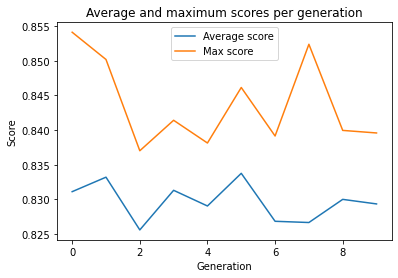

In [73]:
generation_average_scores = np.mean(all_scores, axis=1)
generation_max_scores = np.max(all_scores, axis=1)

fig, ax = plt.subplots()
ax.plot(generation_average_scores, color='tab:blue', label='Average score')
ax.plot(generation_max_scores, color='tab:orange', label='Max score')
ax.set_xlabel('Generation')
ax.set_ylabel('Score')
ax.set_title('Average and maximum scores per generation')
ax.legend()

For more details, we may also plot the evolution of each hyperparameter over all generations.

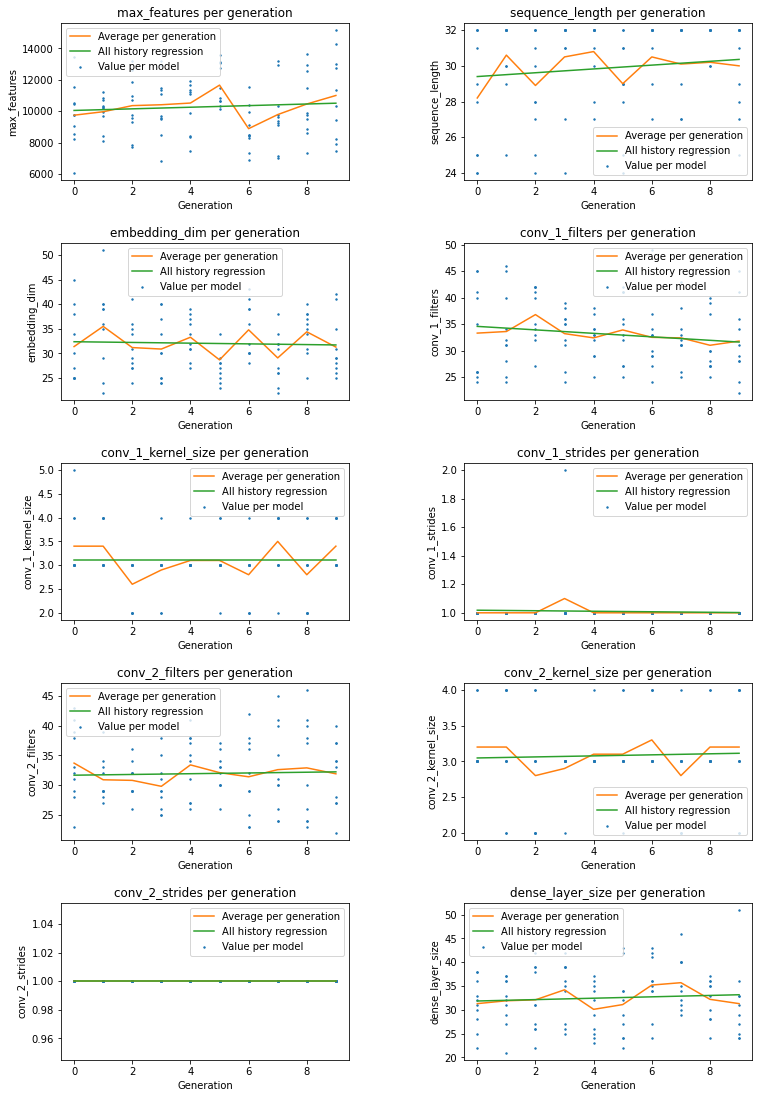

In [74]:
from numpy.polynomial.polynomial import polyfit

x = np.array([i for i in range(n_generations) for j in range(population_size)])

fig, axs = plt.subplots(5, 2, figsize=(12, 18))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
axs = axs.ravel()

i = 0
for param in base_params.keys():
    y = np.array([genotype[param] for population in all_populations for genotype in population])
    mean_x = np.array(range(n_generations))
    mean_y = np.array([np.mean([genotype[param] for genotype in population]) for population in all_populations])
    b, m = polyfit(x, y, deg=1)

    axs[i].scatter(x, y, s=2, color='tab:blue', label='Value per model')
    axs[i].plot(mean_x, mean_y, color='tab:orange', label='Average per generation')
    axs[i].plot(x, m * x + b, color='tab:green', label='All history regression')
    axs[i].set_xlabel('Generation')
    axs[i].set_ylabel(param)
    axs[i].set_title(param + ' per generation')
    axs[i].legend()
    i += 1